In [35]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
import pathlib
from pathlib import Path
import random
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys
if '/content/drive/MyDrive/pytorch/06_modular_py_models' not in sys.path:
    sys.path.append('/content/drive/MyDrive/pytorch/06_modular_py_models')

import data_setup, engine, data_download

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### 1 - Prepare Data

In [4]:
DATA_PATH = '/content/drive/MyDrive/pytorch/data'
train_dir, eval_dir = data_download.download_sample_to_path(DATA_PATH)

/content/drive/MyDrive/pytorch/data/pizza_steak_sushi directory exists.


In [5]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
weights = EfficientNet_B0_Weights.DEFAULT
transform = weights.transforms()
transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [6]:
BATCH_SIZE = 8
train_loader, eval_loader, class_names = data_setup.create_dataloaders(train_dir, eval_dir, transform,
                                                                       batch_size = BATCH_SIZE)
len(train_loader), len(eval_loader), class_names

(29, 10, ['pizza', 'steak', 'sushi'])

### 2 - Define model
- default all layers trainable

In [7]:
model = efficientnet_b0(weights = weights)

In [8]:
model.avgpool # different components

AdaptiveAvgPool2d(output_size=1)

In [9]:
model.classifier # different components

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [10]:
model.features # the CNN layers

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [11]:
# freeze base layers
for param in model.features.parameters():
    param.requires_grad = False

In [12]:

model.classifier = nn.Sequential(
    nn.Dropout(p = 0.2, inplace = True),
    nn.Linear(in_features = 1280, out_features = len(class_names))
)

model = model.to(device)

### 3 - Train Model

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = 0.001)

In [14]:
result = engine.train(model, train_loader, eval_loader, optimizer, loss_fn,
             20, device = device)

  5%|▌         | 1/20 [00:04<01:18,  4.13s/it]

Epoch: 1 | train_loss: 0.9728 | train_acc: 0.5647 | test_loss: 0.7581 | test_acc: 0.7750


 10%|█         | 2/20 [00:06<01:00,  3.37s/it]

Epoch: 2 | train_loss: 0.6968 | train_acc: 0.7543 | test_loss: 0.6376 | test_acc: 0.8000


 15%|█▌        | 3/20 [00:09<00:53,  3.12s/it]

Epoch: 3 | train_loss: 0.5508 | train_acc: 0.8621 | test_loss: 0.5635 | test_acc: 0.8375


 20%|██        | 4/20 [00:14<00:58,  3.66s/it]

Epoch: 4 | train_loss: 0.4927 | train_acc: 0.8707 | test_loss: 0.4757 | test_acc: 0.8750


 25%|██▌       | 5/20 [00:17<00:51,  3.45s/it]

Epoch: 5 | train_loss: 0.4601 | train_acc: 0.8578 | test_loss: 0.4583 | test_acc: 0.8375


 30%|███       | 6/20 [00:20<00:45,  3.22s/it]

Epoch: 6 | train_loss: 0.4281 | train_acc: 0.8448 | test_loss: 0.4369 | test_acc: 0.8375


 35%|███▌      | 7/20 [00:22<00:40,  3.08s/it]

Epoch: 7 | train_loss: 0.3992 | train_acc: 0.8879 | test_loss: 0.4153 | test_acc: 0.8625


 40%|████      | 8/20 [00:26<00:39,  3.32s/it]

Epoch: 8 | train_loss: 0.3814 | train_acc: 0.8707 | test_loss: 0.3926 | test_acc: 0.8625


 45%|████▌     | 9/20 [00:30<00:36,  3.36s/it]

Epoch: 9 | train_loss: 0.3439 | train_acc: 0.8836 | test_loss: 0.3733 | test_acc: 0.8500


 50%|█████     | 10/20 [00:33<00:31,  3.19s/it]

Epoch: 10 | train_loss: 0.3518 | train_acc: 0.9224 | test_loss: 0.3533 | test_acc: 0.8625


 55%|█████▌    | 11/20 [00:35<00:27,  3.06s/it]

Epoch: 11 | train_loss: 0.3150 | train_acc: 0.9224 | test_loss: 0.3640 | test_acc: 0.8625


 60%|██████    | 12/20 [00:38<00:24,  3.03s/it]

Epoch: 12 | train_loss: 0.2799 | train_acc: 0.8879 | test_loss: 0.3735 | test_acc: 0.8875


 65%|██████▌   | 13/20 [00:43<00:24,  3.43s/it]

Epoch: 13 | train_loss: 0.3398 | train_acc: 0.8707 | test_loss: 0.3427 | test_acc: 0.8875


 70%|███████   | 14/20 [00:45<00:19,  3.24s/it]

Epoch: 14 | train_loss: 0.2341 | train_acc: 0.9440 | test_loss: 0.3520 | test_acc: 0.8750


 75%|███████▌  | 15/20 [00:48<00:15,  3.13s/it]

Epoch: 15 | train_loss: 0.3241 | train_acc: 0.9052 | test_loss: 0.3301 | test_acc: 0.8750


 80%|████████  | 16/20 [00:52<00:12,  3.21s/it]

Epoch: 16 | train_loss: 0.2740 | train_acc: 0.9095 | test_loss: 0.3743 | test_acc: 0.8875


 85%|████████▌ | 17/20 [00:56<00:11,  3.67s/it]

Epoch: 17 | train_loss: 0.2972 | train_acc: 0.8879 | test_loss: 0.3430 | test_acc: 0.8625


 90%|█████████ | 18/20 [00:59<00:06,  3.42s/it]

Epoch: 18 | train_loss: 0.3172 | train_acc: 0.8578 | test_loss: 0.3234 | test_acc: 0.8875


 95%|█████████▌| 19/20 [01:02<00:03,  3.23s/it]

Epoch: 19 | train_loss: 0.2734 | train_acc: 0.8836 | test_loss: 0.3376 | test_acc: 0.8625


100%|██████████| 20/20 [01:05<00:00,  3.27s/it]

Epoch: 20 | train_loss: 0.3162 | train_acc: 0.8750 | test_loss: 0.3264 | test_acc: 0.8750


### 4 - evaluate model

In [15]:
result

{'train_loss': [0.9728308977751896,
  0.6967575632292649,
  0.550769240691744,
  0.49265243113040924,
  0.46011570918148964,
  0.42810124210242567,
  0.3992251065270654,
  0.38137091028279274,
  0.3438907098667375,
  0.35178529625308924,
  0.3149651825941842,
  0.2799370697346227,
  0.339754005958294,
  0.2340941927556334,
  0.32410620743858404,
  0.2740310497325042,
  0.2972418599087617,
  0.31717185727481184,
  0.27342189591506433,
  0.31615604036327066],
 'train_acc': [0.5646551724137931,
  0.7543103448275862,
  0.8620689655172413,
  0.8706896551724138,
  0.8577586206896551,
  0.8448275862068966,
  0.8879310344827587,
  0.8706896551724138,
  0.8836206896551724,
  0.9224137931034483,
  0.9224137931034483,
  0.8879310344827587,
  0.8706896551724138,
  0.9439655172413793,
  0.9051724137931034,
  0.9094827586206896,
  0.8879310344827587,
  0.8577586206896551,
  0.8836206896551724,
  0.875],
 'test_loss': [0.7580585360527039,
  0.6376329451799393,
  0.5635398536920547,
  0.47567681074142

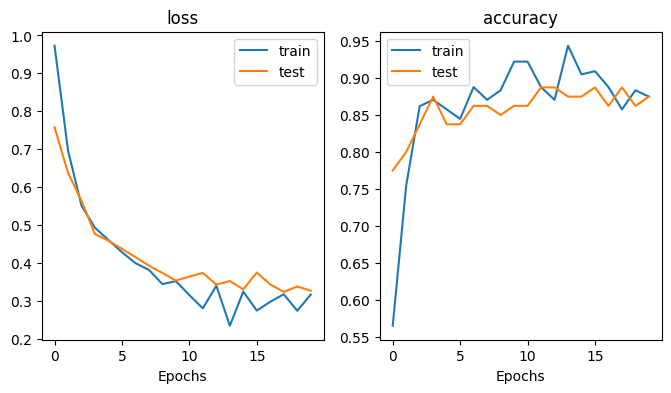

In [16]:
def plot_results(result):
    epochs = range(len(result['test_loss']))
    plt.figure(figsize = (8, 4))
    plt.subplot(1, 2, 1)
    plt.title('loss')
    plt.xlabel('Epochs')
    plt.plot(epochs, result['train_loss'], label = 'train')
    plt.plot(epochs, result['test_loss'], label = 'test')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('accuracy')
    plt.xlabel('Epochs')
    plt.plot(epochs, result['train_acc'], label = 'train')
    plt.plot(epochs, result['test_acc'], label = 'test')
    plt.legend()

    plt.show()

plot_results(result)

In [20]:
model_save_path = '/content/drive/MyDrive/pytorch/models'
model_name = '7_transfer_learning_efficientnet_b0.pth'
engine.save_model(model, model_save_path, model_name)

[INFO] Saving model to: /content/drive/MyDrive/pytorch/models/7_transfer_learning_efficientnet_b0.pth


In [22]:
model.load_state_dict(torch.load(model_save_path + '/' + model_name,
                                 map_location = torch.device(device)))

<ipython-input-22-8d6daee399c9>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path + '/' + model_name,


<All keys matched successfully>

In [26]:
def plot_prediction(image_path, model, transform, classes):
    img = Image.open(image_path)
    img_tensor = transform(img).unsqueeze(0).to(device)
    model.eval()
    with torch.inference_mode():
        prediction = model(img_tensor).cpu().squeeze().argmax()
    plt.title(classes[prediction])
    plt.imshow(img_tensor.squeeze().cpu().permute(1, 2, 0))
    plt.axis(False)

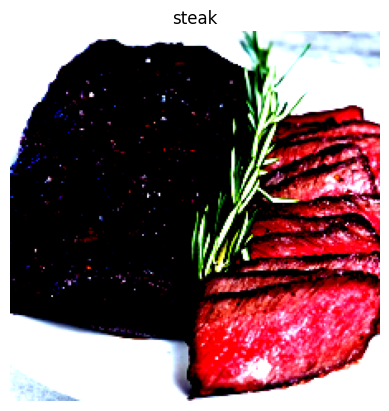

In [29]:
IMG_PATH = '/content/drive/MyDrive/pytorch/data/sample_steak.jpg'
plot_prediction(IMG_PATH, model = model, transform = transform,
                classes = class_names)

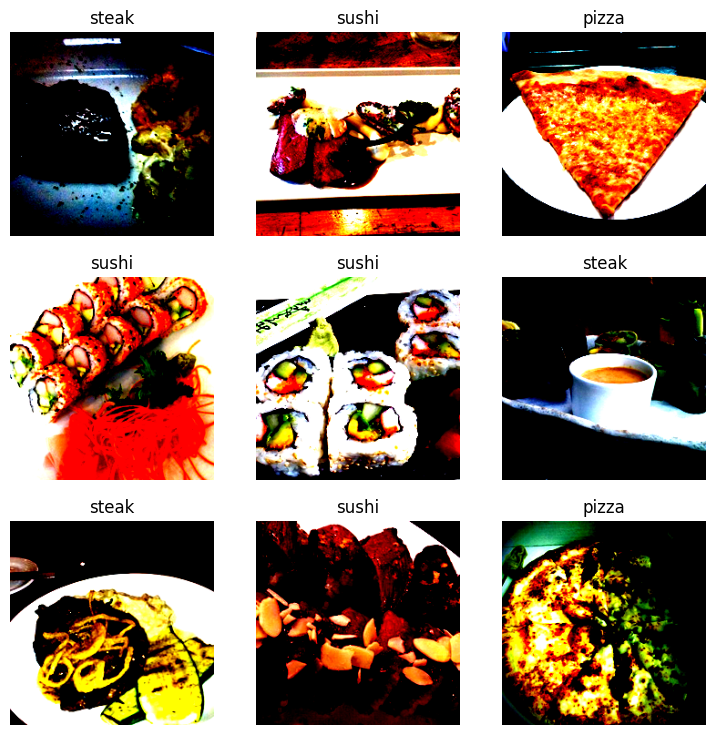

In [36]:
random_list = list(eval_dir.glob('*/*.jpg'))

plt.figure(figsize = (9, 9))
for i in range(9):
    random_image_path = random.choice(random_list)
    plt.subplot(3, 3, i + 1)
    plot_prediction(random_image_path, model = model, transform = transform,
                    classes = class_names)

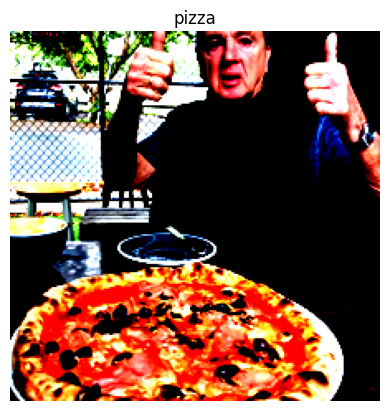

In [37]:

IMG_PATH = '/content/drive/MyDrive/pytorch/data/pizza-dad.jpeg'
plot_prediction(IMG_PATH, model = model, transform = transform,
                classes = class_names)